In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import warnings

In [51]:
# Set up visualization style
sns.set_palette("husl")
warnings.filterwarnings('ignore')

In [ ]:
def load_producer_metrics(producer_dir):
    """Load all metrics for a single producer from separate CSV files with specific naming"""
    metrics = {}
    
    # Mapping of our metric names to your filenames
    file_mapping = {
        'CPU': 'CPU.csv',
        'Memory': 'Memory.csv',
        'Disk read': 'Disk_read.csv',
        'Disk write': 'Disk_write.csv',
        'Network received': 'Network_received.csv',
        'Network sent': 'Network_sent.csv',
        'Messages consumption time': 'Msg_cons_time.csv',
        'Consumption lag': 'Cons_lag.csv',
        'Average latency': 'Avg_latency.csv',
        'Throughput': 'Throughput.csv',
        'Frames produced': 'Frame_prod.csv',
        'Messages consumed': 'Msg_cons.csv'
    }
    
    for metric_name, file_name in file_mapping.items():
        file_path = Path(producer_dir) / file_name
        if file_path.exists():
            try:
                df = pd.read_csv(file_path, header=None, names=['timestamp', 'value'])
                metrics[metric_name] = df
            except Exception as e:
                print(f"Warning: Could not read {file_path}: {str(e)}")
                metrics[metric_name] = pd.DataFrame(columns=['timestamp', 'value'])
        else:
            print(f"Warning: File not found - {file_path}")
            metrics[metric_name] = pd.DataFrame(columns=['timestamp', 'value'])
    
    return metrics

In [23]:
def calculate_producer_stats(metrics):
    """Calculate statistics from a producer's metrics"""
    stats = {}
    
    # Performance Overview
    if not metrics['Frames produced'].empty:
        stats['frame_production_rate'] = metrics['Frames produced']['value'].diff().mean()  # FPS as rate of change
        stats['frames_produced_total'] = metrics['Frames produced']['value'].iloc[-1]  # Assuming cumulative
    else:
        stats['frame_production_rate'] = 0
        stats['frames_produced_total'] = 0
    
    if not metrics['Average latency'].empty:
        stats['avg_latency'] = metrics['Average latency']['value'].mean() * 1000  # Convert to ms
    else:
        stats['avg_latency'] = 0
    
    if not metrics['Consumption lag'].empty:
        stats['consumer_lag'] = metrics['Consumption lag']['value'].mean()
    else:
        stats['consumer_lag'] = 0
    
    if not metrics['Messages consumption time'].empty:
        stats['message_consumption_time'] = metrics['Messages consumption time']['value'].mean() * 1000  # Convert to ms
    else:
        stats['message_consumption_time'] = 0
    
    if not metrics['Messages consumed'].empty:
        stats['messages_consumed_total'] = metrics['Messages consumed']['value'].iloc[-1]  # Assuming cumulative
    else:
        stats['messages_consumed_total'] = 0
    
    # Resource Utilization
    if not metrics['CPU'].empty:
        stats['cpu_usage'] = metrics['CPU']['value'].mean()
    else:
        stats['cpu_usage'] = 0
    
    if not metrics['Memory'].empty:
        stats['memory_usage'] = metrics['Memory']['value'].mean()
    else:
        stats['memory_usage'] = 0
    
    if not metrics['Disk read'].empty and not metrics['Disk write'].empty:
        stats['disk_read_write'] = (metrics['Disk read']['value'].mean() + metrics['Disk write']['value'].mean()) / 2
    else:
        stats['disk_read_write'] = 0
    
    if not metrics['Network received'].empty and not metrics['Network sent'].empty:
        stats['network_io'] = (metrics['Network received']['value'].mean() + metrics['Network sent']['value'].mean()) / 2
    else:
        stats['network_io'] = 0
    
    # Throughput Analysis
    if not metrics['Throughput'].empty:
        stats['avg_throughput'] = metrics['Throughput']['value'].mean()
        stats['peak_throughput'] = metrics['Throughput']['value'].max()
    else:
        stats['avg_throughput'] = 0
        stats['peak_throughput'] = 0
    
    # Latency Analysis
    if not metrics['Average latency'].empty:
        stats['p99_latency'] = metrics['Average latency']['value'].quantile(0.99) * 1000  # Convert to ms
    else:
        stats['p99_latency'] = 0
    
    return stats

In [24]:
def analyze_all_producers(base_dir):
    """Analyze all producers in the base directory"""
    producer_dirs = glob.glob(f"{base_dir}/*/")  # Get all subdirectories
    
    all_stats = {}
    
    for producer_dir in producer_dirs:
        producer_name = Path(producer_dir).name
        try:
            print(f"Processing {producer_name}...")
            metrics = load_producer_metrics(producer_dir)
            stats = calculate_producer_stats(metrics)
            all_stats[producer_name] = stats
        except Exception as e:
            print(f"Error processing {producer_name}: {str(e)}")
    
    return all_stats

In [15]:
def print_performance_overview(stats_dict):
    """Print Performance Overview table"""
    print("\nTable X - Real-Time Video Processing Metrics by Producer")
    print("{:<15} {:<25} {:<20} {:<15} {:<15} {:<25} {:<20}".format(
        "Producer", "Frame Production Rate (fps)", "Frames Produced (total)", 
        "Avg Latency (ms)", "Consumer Lag (ms)", "Message Consumpt. Time (ms)", 
        "Messages Consumed (total)"))
    
    for producer, stats in stats_dict.items():
        print("{:<15} {:<25.2f} {:<20.2f} {:<15.2f} {:<15.2f} {:<25.2f} {:<20.2f}".format(
            producer, stats['frame_production_rate'], stats['frames_produced_total'],
            stats['avg_latency'], stats['consumer_lag'], 
            stats['message_consumption_time'], stats['messages_consumed_total']))

In [16]:
def print_resource_utilization(stats_dict):
    """Print Resource Utilization table"""
    print("\nTable X - Resource Utilization by Producer")
    print("{:<15} {:<15} {:<15} {:<20} {:<15}".format(
        "Producer", "CPU Usage (%)", "Memory Usage (MB)", 
        "Disk Read/Write (MB/s)", "Network I/O (MB/s)"))
    
    for producer, stats in stats_dict.items():
        print("{:<15} {:<15.2f} {:<15.2f} {:<20.2f} {:<15.2f}".format(
            producer, stats['cpu_usage'], stats['memory_usage'],
            stats['disk_read_write'], stats['network_io']))

In [17]:
def print_throughput_analysis(stats_dict):
    """Print Throughput Analysis table"""
    print("\nTable X - Throughput by Producer")
    print("{:<15} {:<20} {:<20} {:<15} {:<15}".format(
        "Producer", "Avg. Throughput (fps)", "Peak Throughput (fps)", 
        "CPU Usage (%)", "Memory usage (MB)"))
    
    for producer, stats in stats_dict.items():
        print("{:<15} {:<20.2f} {:<20.2f} {:<15.2f} {:<15.2f}".format(
            producer, stats['avg_throughput'], stats['peak_throughput'],
            stats['cpu_usage'], stats['memory_usage']))

In [18]:
def print_latency_analysis(stats_dict):
    """Print Latency Analysis table"""
    print("\nTable X - Latency by Producer")
    print("{:<15} {:<20} {:<20} {:<15} {:<15}".format(
        "Producer", "Avg. Latency (ms)", "P99 Latency (ms)", 
        "CPU Usage (%)", "Memory usage (MB)"))
    
    for producer, stats in stats_dict.items():
        print("{:<15} {:<20.2f} {:<20.2f} {:<15.2f} {:<15.2f}".format(
            producer, stats['avg_latency'], stats['p99_latency'],
            stats['cpu_usage'], stats['memory_usage']))

In [25]:
def write_results_to_file(results, output_file="results.txt"):
    """Write all analysis results to a file with timestamp"""
    with open(output_file, 'w') as f:
        # Write header with timestamp
        f.write(f"Performance Analysis Results - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*50 + "\n\n")
        
        # Performance Overview
        f.write("Table X - Real-Time Video Processing Metrics by Producer\n")
        f.write("{:<15} {:<25} {:<20} {:<15} {:<15} {:<25} {:<20}\n".format(
            "Producer", "Frame Production Rate (fps)", "Frames Produced (total)", 
            "Avg Latency (ms)", "Consumer Lag (ms)", "Message Consumpt. Time (ms)", 
            "Messages Consumed (total)"))
        
        for producer, stats in results.items():
            f.write("{:<15} {:<25.2f} {:<20.2f} {:<15.2f} {:<15.2f} {:<25.2f} {:<20.2f}\n".format(
                producer, stats['frame_production_rate'], stats['frames_produced_total'],
                stats['avg_latency'], stats['consumer_lag'], 
                stats['message_consumption_time'], stats['messages_consumed_total']))
        
        f.write("\n")
        
        # Resource Utilization
        f.write("Table X - Resource Utilization by Producer\n")
        f.write("{:<15} {:<15} {:<15} {:<20} {:<15}\n".format(
            "Producer", "CPU Usage (%)", "Memory Usage (MB)", 
            "Disk Read/Write (MB/s)", "Network I/O (MB/s)"))
        
        for producer, stats in results.items():
            f.write("{:<15} {:<15.2f} {:<15.2f} {:<20.2f} {:<15.2f}\n".format(
                producer, stats['cpu_usage'], stats['memory_usage'],
                stats['disk_read_write'], stats['network_io']))
        
        f.write("\n")
        
        # Throughput Analysis
        f.write("Table X - Throughput by Producer\n")
        f.write("{:<15} {:<20} {:<20} {:<15} {:<15}\n".format(
            "Producer", "Avg. Throughput (fps)", "Peak Throughput (fps)", 
            "CPU Usage (%)", "Memory usage (MB)"))
        
        for producer, stats in results.items():
            f.write("{:<15} {:<20.2f} {:<20.2f} {:<15.2f} {:<15.2f}\n".format(
                producer, stats['avg_throughput'], stats['peak_throughput'],
                stats['cpu_usage'], stats['memory_usage']))
        
        f.write("\n")
        
        # Latency Analysis
        f.write("Table X - Latency by Producer\n")
        f.write("{:<15} {:<20} {:<20} {:<15} {:<15}\n".format(
            "Producer", "Avg. Latency (ms)", "P99 Latency (ms)", 
            "CPU Usage (%)", "Memory usage (MB)"))
        
        for producer, stats in results.items():
            f.write("{:<15} {:<20.2f} {:<20.2f} {:<15.2f} {:<15.2f}\n".format(
                producer, stats['avg_latency'], stats['p99_latency'],
                stats['cpu_usage'], stats['memory_usage']))
        
        print(f"\nResults successfully written to {output_file}")

In [26]:
if __name__ == "__main__":
    base_directory = "data"  # Your base directory containing producer folders
    output_filename = "performance_results.txt"
    
    # Analyze all producers
    all_stats = analyze_all_producers(base_directory)
    
    # Write results to file
    write_results_to_file(all_stats, output_filename)
    
    # Also print to console (optional)
    # Uncomment these if needed to see results in console too
    # print_performance_overview(all_stats)
    # print_resource_utilization(all_stats)
    # print_throughput_analysis(all_stats)
    # print_latency_analysis(all_stats)

Processing fs2...
Processing akka...
Processing kafka...
Processing zio...
Processing cats...

Results successfully written to performance_results.txt


In [52]:
# ==============================================
# 1. DATA LOADING & PREPROCESSING
# ==============================================

In [53]:
def load_metric(file_path, metric_name):
    """Load single metric CSV with robust timestamp handling"""
    try:
        df = pd.read_csv(file_path, header=None, names=['timestamp', metric_name])
        
        # Convert timestamp with multiple format attempts
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S')
        except:
            try:
                df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
            except:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Handle duplicates by averaging
        return df.groupby('timestamp').mean().reset_index()
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

In [54]:
def load_producer_data(producer_dir):
    """Load all metrics for a producer"""
    file_mapping = {
        'CPU': 'CPU.csv',
        'Memory': 'Memory.csv',
        'Disk_read': 'Disk_read.csv',
        'Disk_write': 'Disk_write.csv',
        'Network_received': 'Network_received.csv',
        'Network_sent': 'Network_sent.csv',
        'Msg_cons_time': 'Msg_cons_time.csv',
        'Cons_lag': 'Cons_lag.csv',
        'Avg_latency': 'Avg_latency.csv',
        'Throughput': 'Throughput.csv',
        'Frame_prod': 'Frame_prod.csv',
        'Msg_cons': 'Msg_cons.csv'
    }
    
    dfs = []
    for metric_name, file_name in file_mapping.items():
        file_path = Path(producer_dir) / file_name
        if file_path.exists():
            df = load_metric(file_path, metric_name)
            if not df.empty:
                dfs.append(df.set_index('timestamp'))
    
    if dfs:
        # Merge all metrics with forward filling
        combined = pd.concat(dfs, axis=1).sort_index()
        return combined.ffill().interpolate().fillna(0)
    return pd.DataFrame()

In [55]:
def load_all_producers(base_dir="data"):
    """Load all producers' data"""
    return {
        Path(producer_dir).name: load_producer_data(producer_dir)
        for producer_dir in glob.glob(f"{base_dir}/*/")
        if not load_producer_data(producer_dir).empty
    }


In [56]:
# ==============================================
# 2. CORE ANALYSIS FUNCTIONS
# ==============================================

In [57]:
def plot_correlations(data, title):
    """Plot correlation heatmap"""
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', 
                center=0, fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix - {title}')
    plt.tight_layout()
    plt.show()

In [58]:
def time_series_decomposition(data, metric, period=30):
    """Decompose time series into components"""
    decomposition = seasonal_decompose(data[metric].dropna(), 
                                     period=period, model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.suptitle(f'Time Series Decomposition - {metric}')
    plt.tight_layout()
    plt.show()
    
    return decomposition

In [59]:
# ==============================================
# 3. CRITICAL PERFORMANCE ANALYSES
# ==============================================

In [60]:
def bottleneck_analysis(data, producer_name):
    """Identify system bottlenecks"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # CPU vs Throughput
    sns.scatterplot(data=data, x='CPU', y='Throughput', ax=axes[0, 0])
    axes[0, 0].set_title('CPU vs Throughput')
    
    # Memory vs Latency
    sns.scatterplot(data=data, x='Memory', y='Avg_latency', ax=axes[0, 1])
    axes[0, 1].set_title('Memory vs Latency')
    
    # Network vs Frames
    network_total = data['Network_received'] + data['Network_sent']
    sns.scatterplot(x=network_total, y=data['Frame_prod'], ax=axes[1, 0])
    axes[1, 0].set_title('Network I/O vs Frame Production')
    
    # Disk vs Consumption Time
    disk_total = data['Disk_read'] + data['Disk_write']
    sns.scatterplot(x=disk_total, y=data['Msg_cons_time'], ax=axes[1, 1])
    axes[1, 1].set_title('Disk I/O vs Consumption Time')
    
    plt.suptitle(f'Bottleneck Analysis - {producer_name}')
    plt.tight_layout()
    plt.show()
    
    bottlenecks = []
    if (data['CPU'] > 90).any():
        bottlenecks.append("High CPU (>90%)")
    if (data['Memory'] > data['Memory'].quantile(0.9)).any():
        bottlenecks.append("High Memory (top 10%)")
    
    return bottlenecks

In [61]:
def resource_efficiency(data, producer_name):
    """Analyze resource utilization efficiency"""
    data['frames_per_cpu'] = data['Frame_prod'] / (data['CPU'] + 0.01)
    data['frames_per_mem'] = data['Frame_prod'] / (data['Memory'] + 0.01)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    data['frames_per_cpu'].plot(ax=axes[0], title='Frames per CPU %')
    data['frames_per_mem'].plot(ax=axes[1], title='Frames per Memory MB')
    plt.suptitle(f'Resource Efficiency - {producer_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'avg_cpu_efficiency': data['frames_per_cpu'].mean(),
        'avg_mem_efficiency': data['frames_per_mem'].mean()
    }

In [62]:
# ==============================================
# 4. EXECUTION & REPORTING
# ==============================================

In [63]:
def analyze_producer(name, data):
    """Run full analysis for one producer"""
    print(f"\n{'='*50}")
    print(f"ANALYZING: {name.upper()}")
    print(f"{'='*50}")
    
    # 1. Correlation Analysis
    print("\n[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]")
    plot_correlations(data[['CPU', 'Memory', 'Disk_read', 'Disk_write',
                          'Network_received', 'Network_sent', 
                          'Throughput', 'Avg_latency']], name)
    
    # 2. Time Series Analysis
    print("\n[TIME SERIES DECOMPOSITION]")
    time_series_decomposition(data, 'Throughput')
    
    # 3. Critical Analyses
    print("\n[BOTTLENECK ANALYSIS]")
    bottlenecks = bottleneck_analysis(data, name)
    print("Detected Bottlenecks:", bottlenecks if bottlenecks else "None")
    
    print("\n[RESOURCE EFFICIENCY]")
    efficiency = resource_efficiency(data, name)
    print(f"CPU Efficiency: {efficiency['avg_cpu_efficiency']:.2f} frames/%")
    print(f"Memory Efficiency: {efficiency['avg_mem_efficiency']:.2f} frames/MB")

In [64]:
def generate_report(producers_data):
    """Generate complete analysis report"""
    print("=== KAFKA PRODUCERS PERFORMANCE ANALYSIS REPORT ===")
    print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    for name, data in producers_data.items():
        analyze_producer(name, data)

In [65]:
# ==============================================
# 5. MAIN EXECUTION
# ==============================================

=== KAFKA PRODUCERS PERFORMANCE ANALYSIS REPORT ===
Generated: 2025-04-29 15:46:53


ANALYZING: FS2

[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]


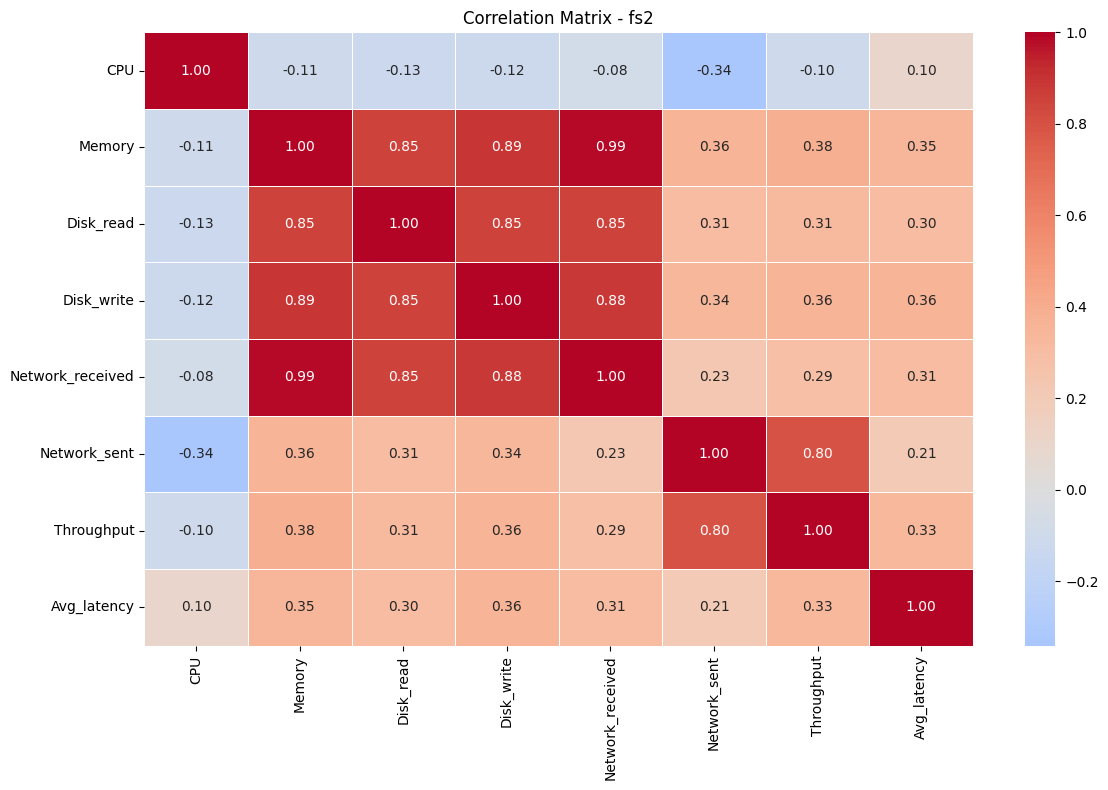


[TIME SERIES DECOMPOSITION]


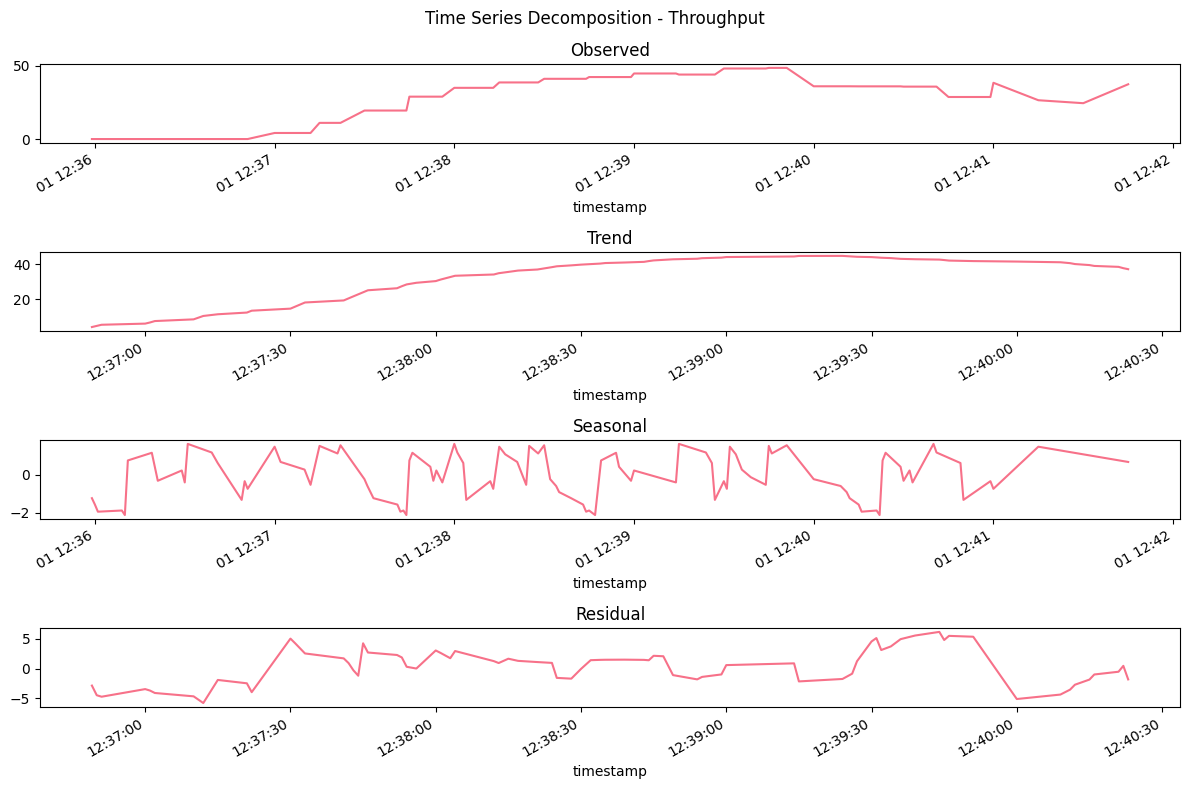


[BOTTLENECK ANALYSIS]


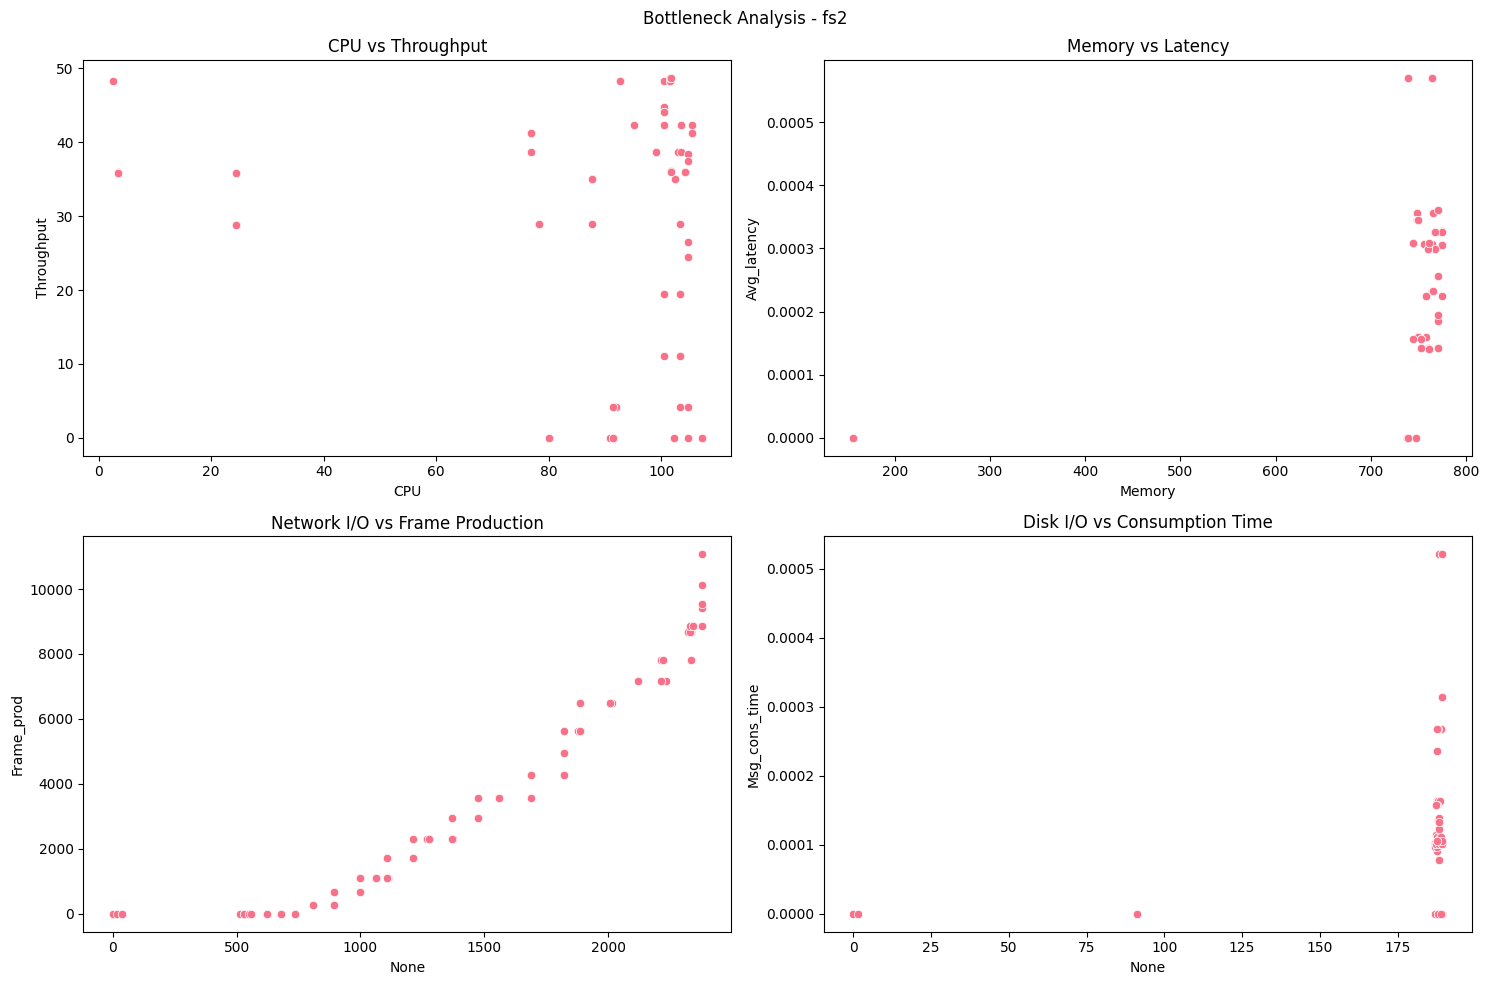

Detected Bottlenecks: ['High CPU (>90%)', 'High Memory (top 10%)']

[RESOURCE EFFICIENCY]


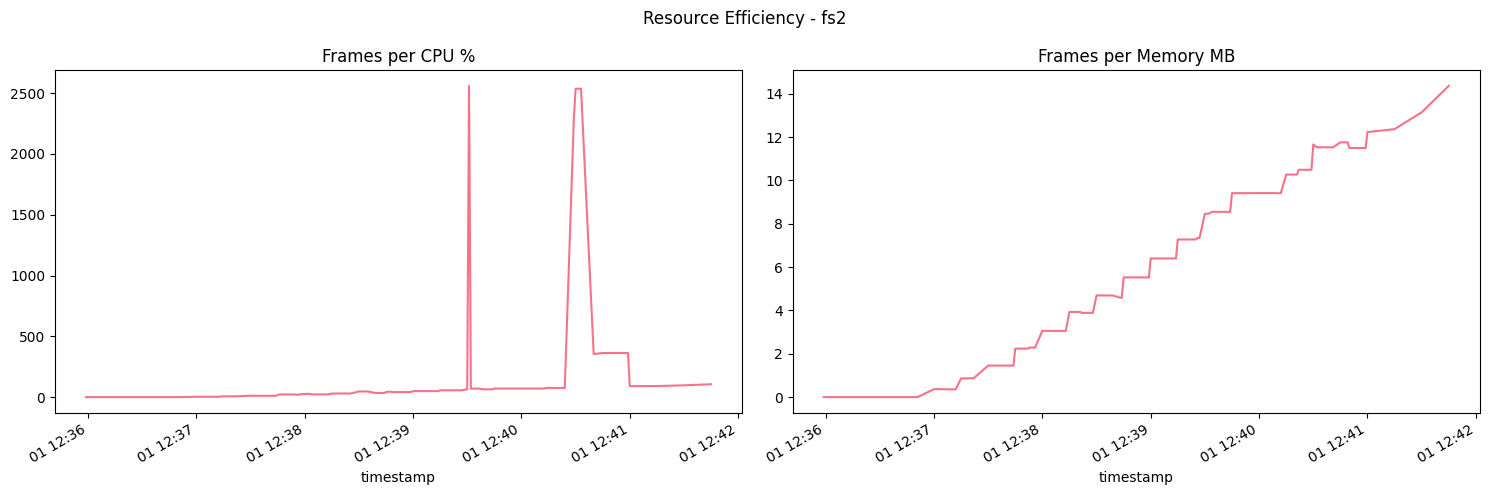

CPU Efficiency: 162.13 frames/%
Memory Efficiency: 5.05 frames/MB

ANALYZING: AKKA

[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]


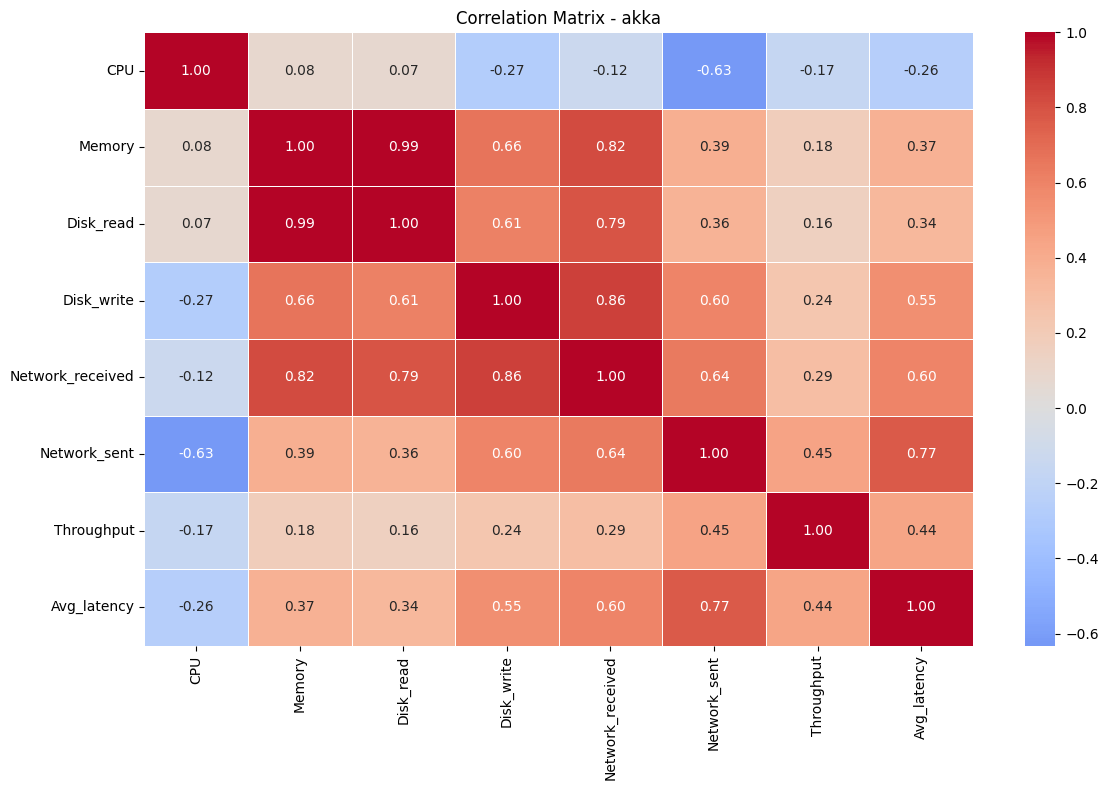


[TIME SERIES DECOMPOSITION]


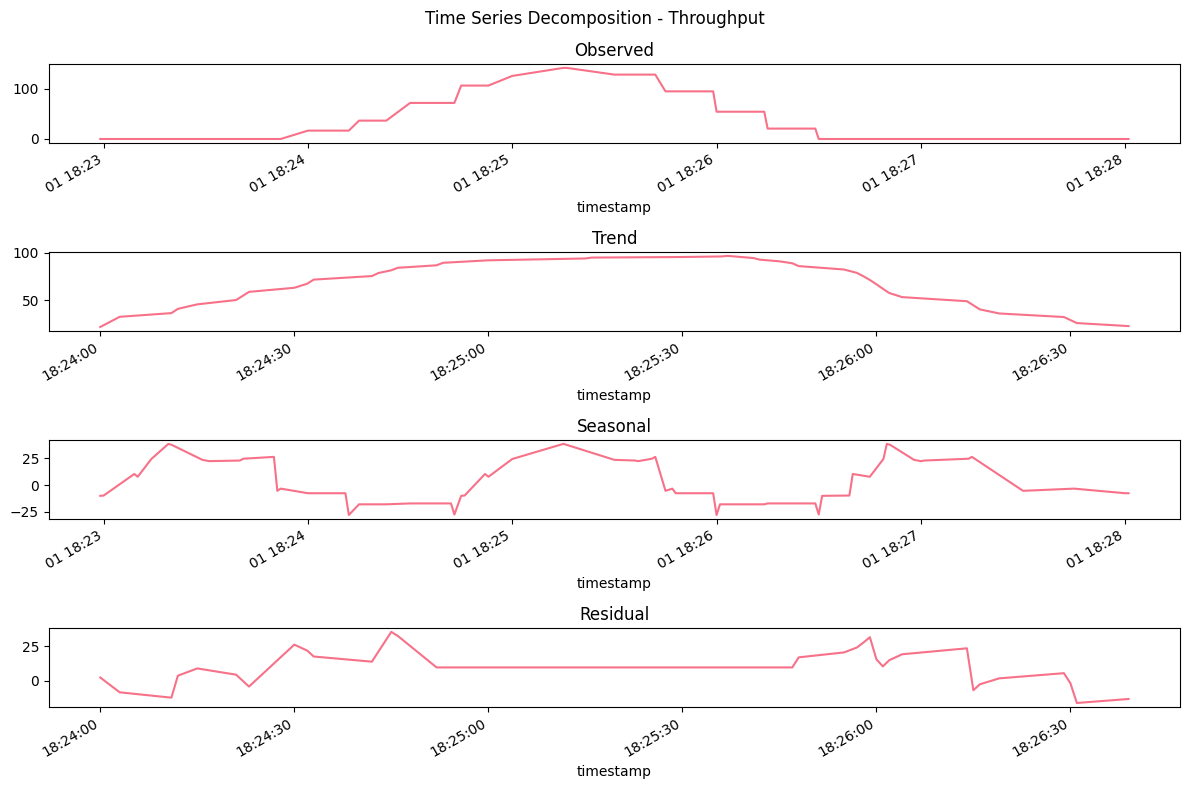


[BOTTLENECK ANALYSIS]


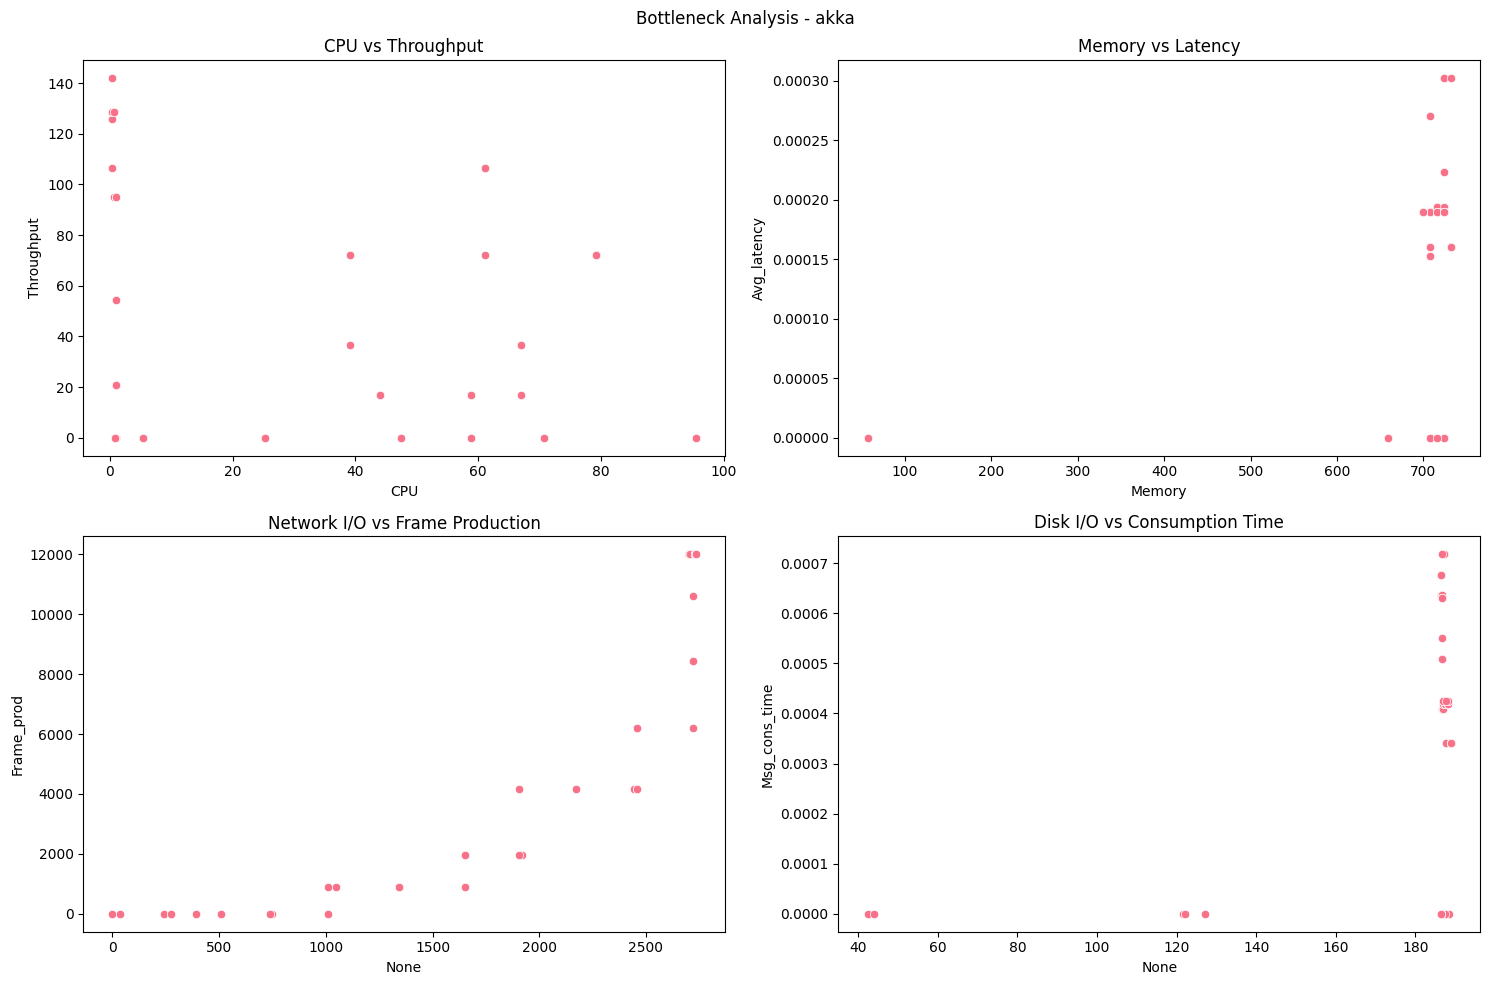

Detected Bottlenecks: ['High CPU (>90%)', 'High Memory (top 10%)']

[RESOURCE EFFICIENCY]


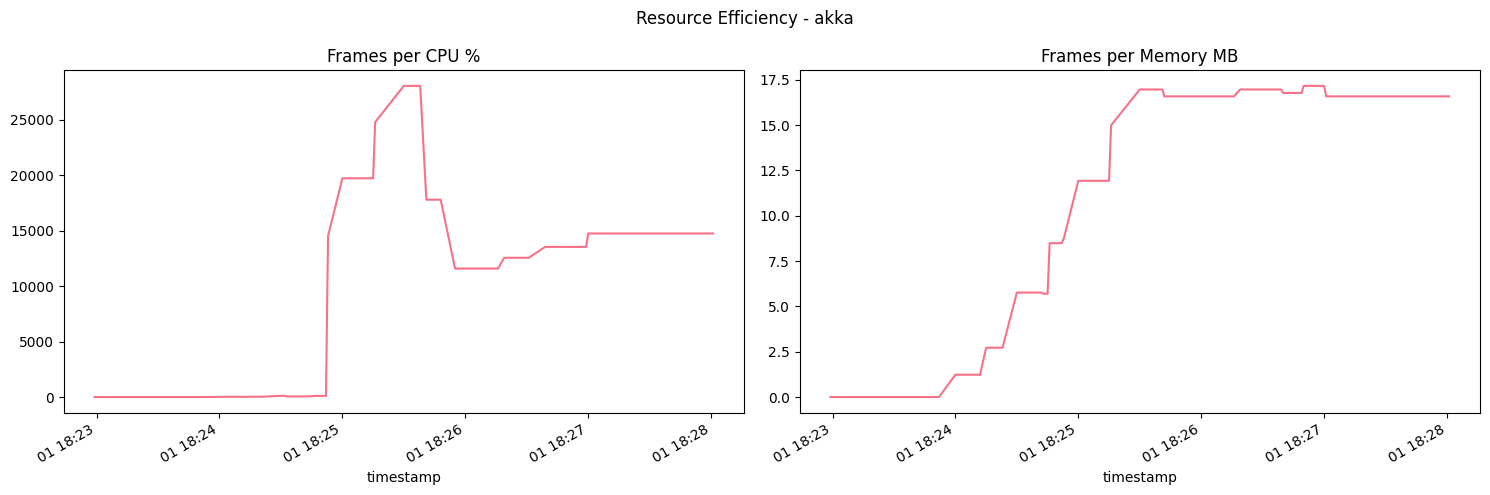

CPU Efficiency: 8887.60 frames/%
Memory Efficiency: 10.23 frames/MB

ANALYZING: KAFKA

[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]


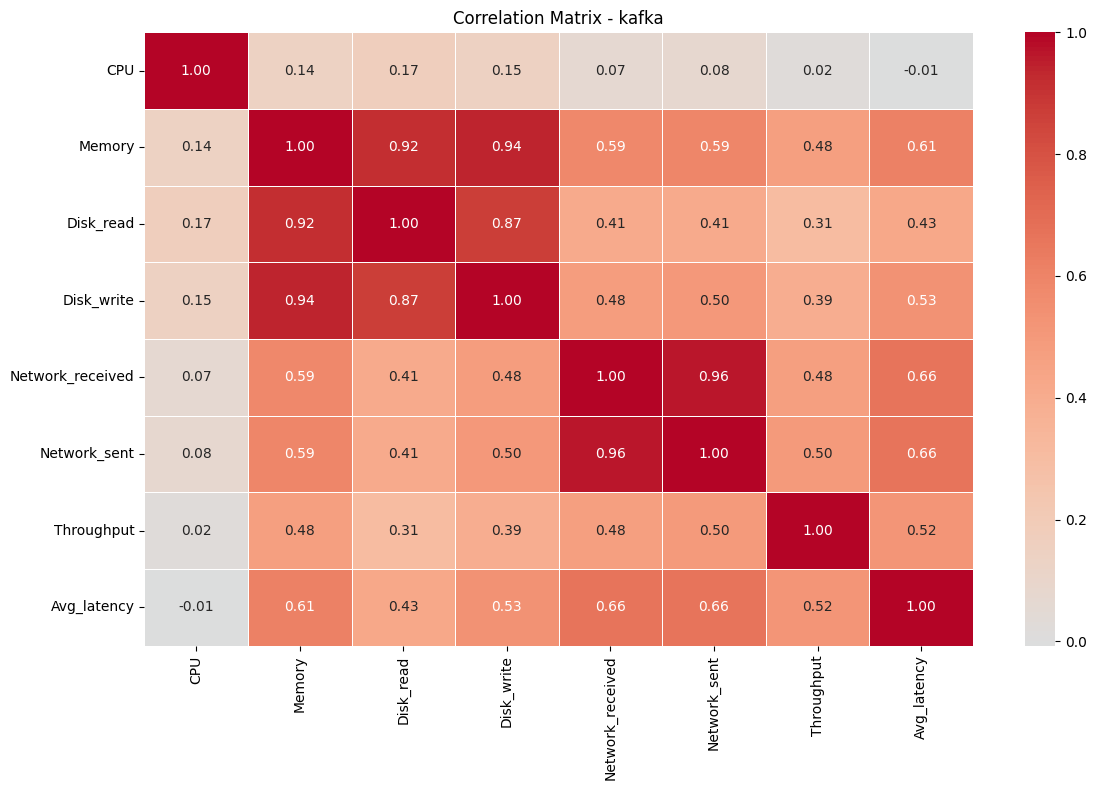


[TIME SERIES DECOMPOSITION]


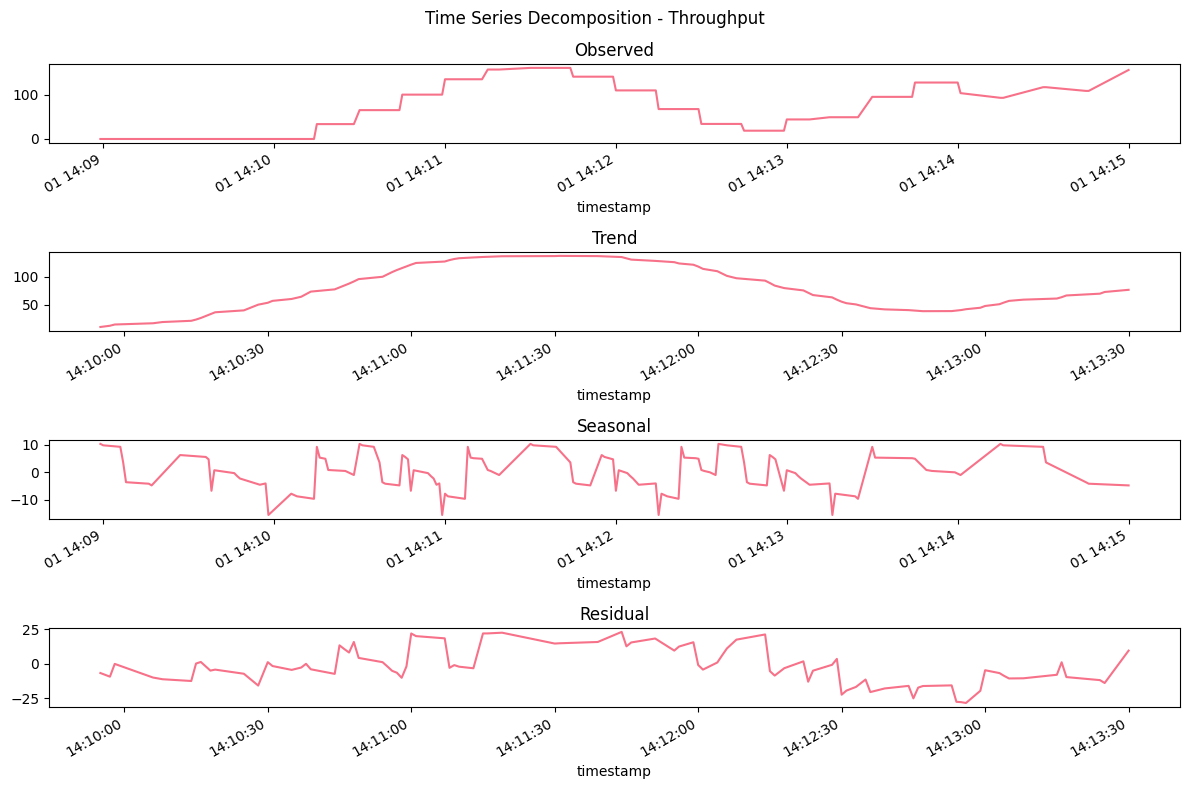


[BOTTLENECK ANALYSIS]


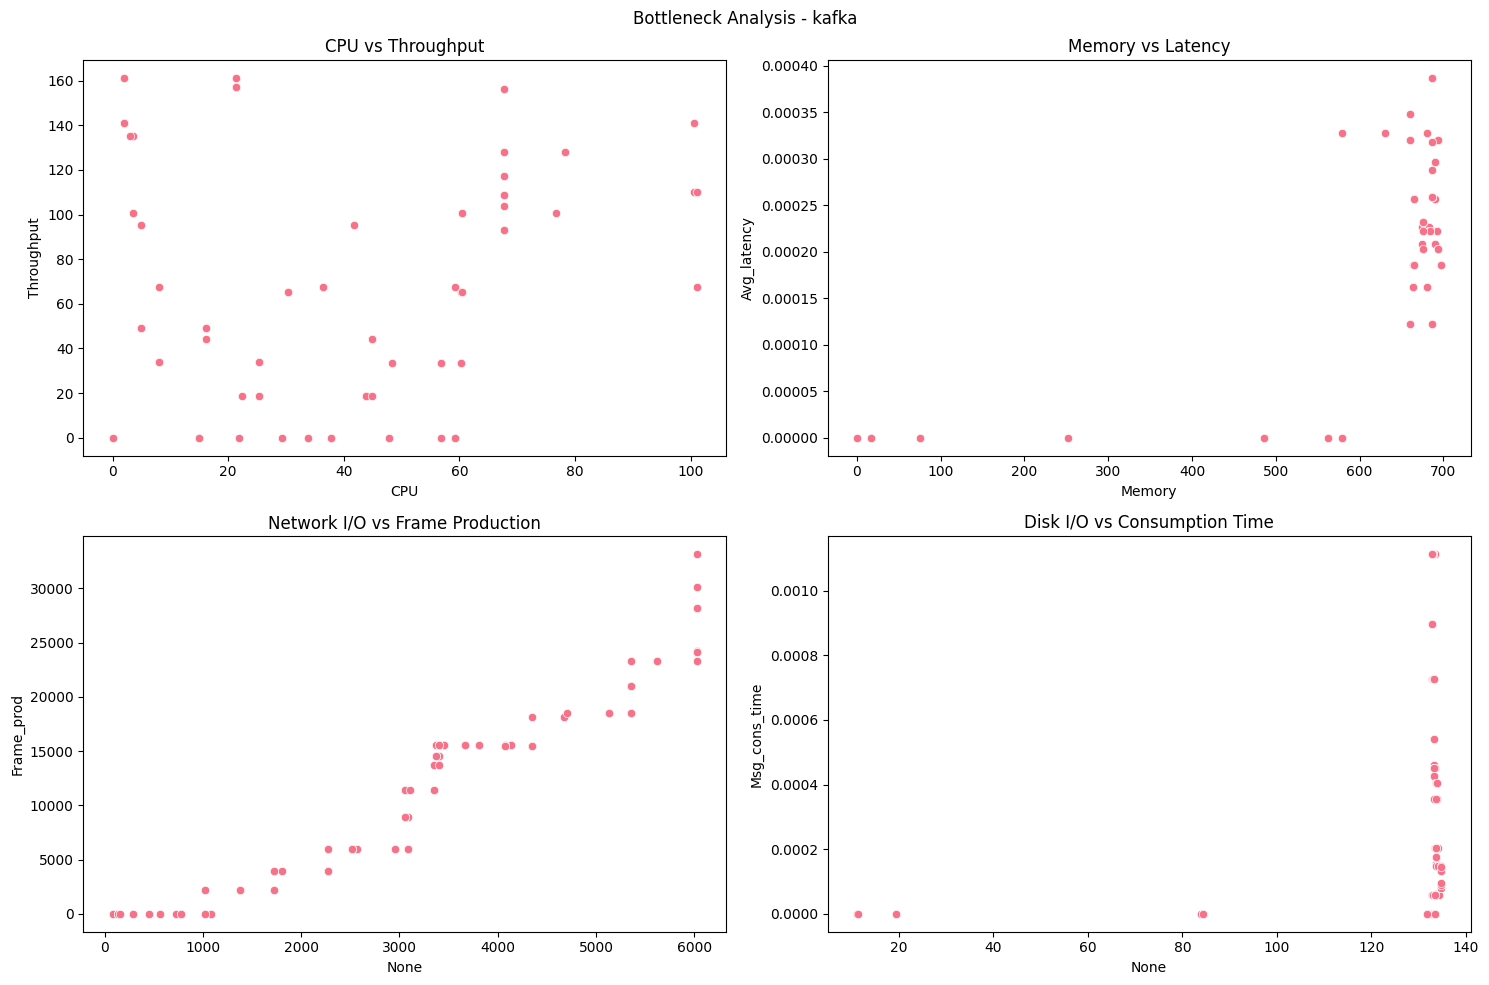

Detected Bottlenecks: ['High CPU (>90%)', 'High Memory (top 10%)']

[RESOURCE EFFICIENCY]


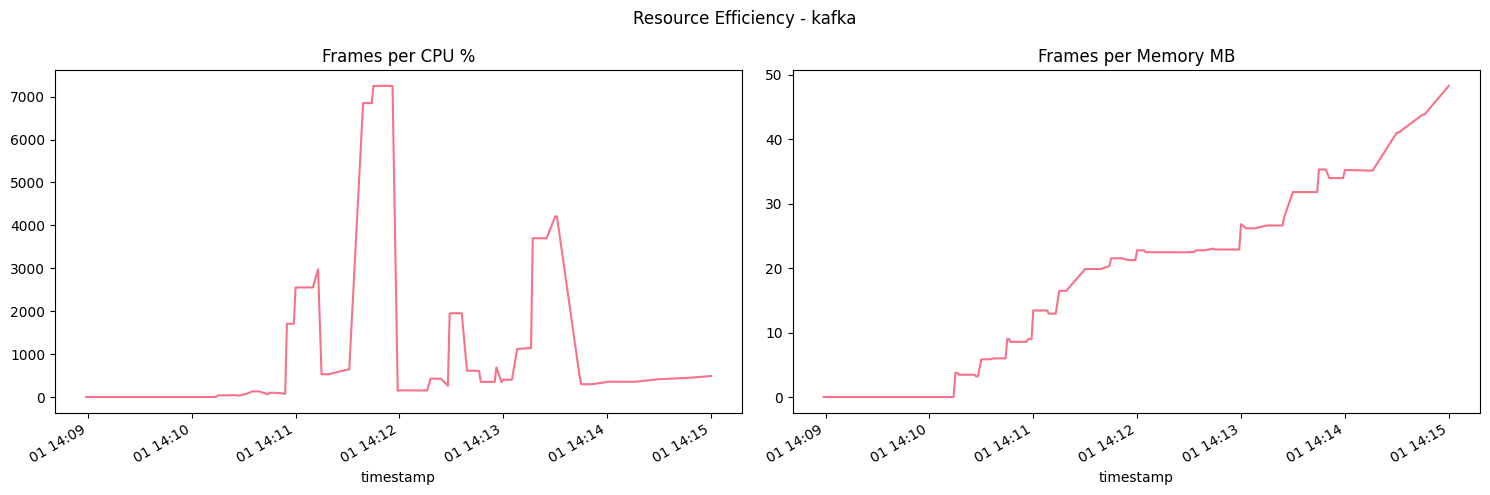

CPU Efficiency: 1057.83 frames/%
Memory Efficiency: 16.64 frames/MB

ANALYZING: ZIO

[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]


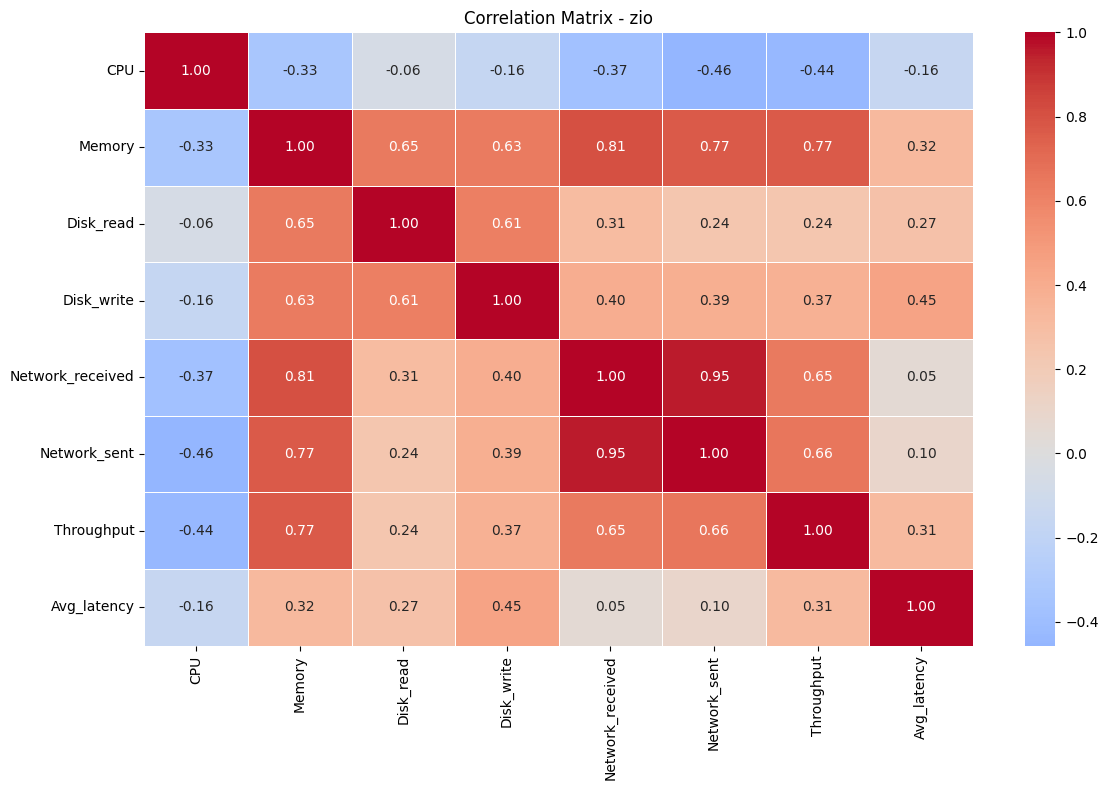


[TIME SERIES DECOMPOSITION]


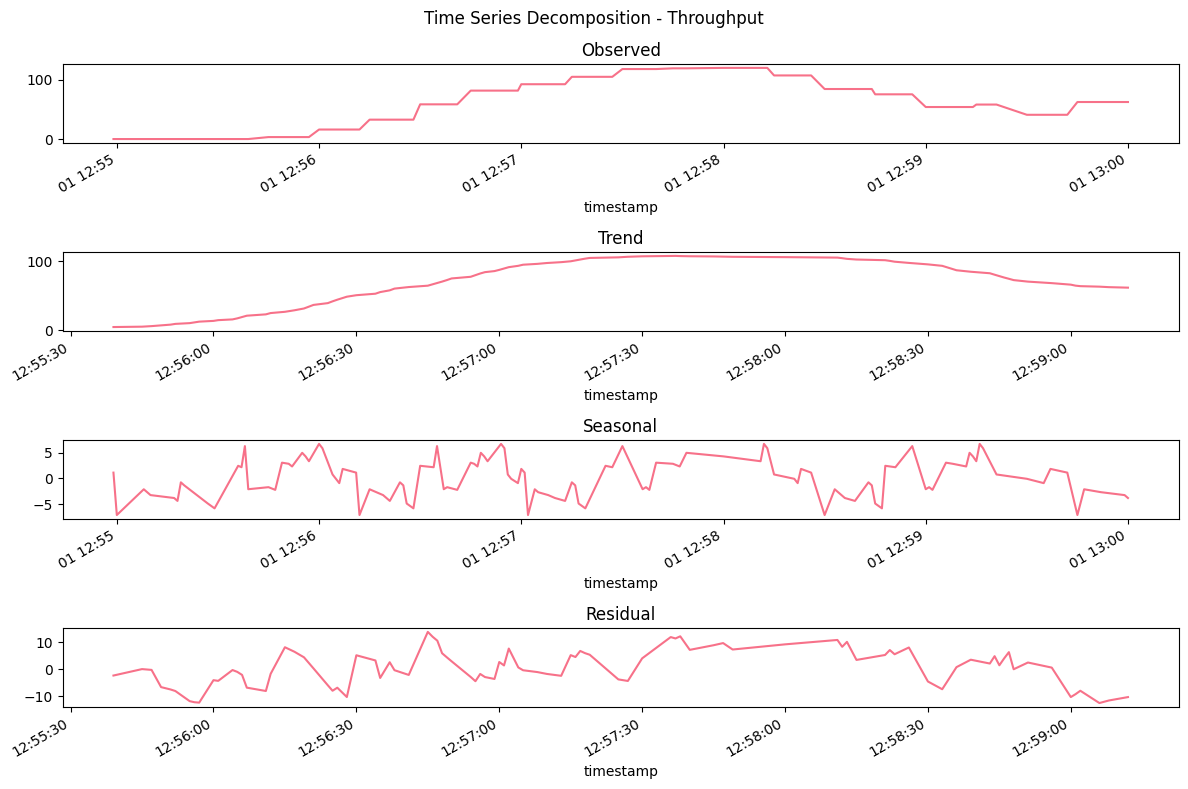


[BOTTLENECK ANALYSIS]


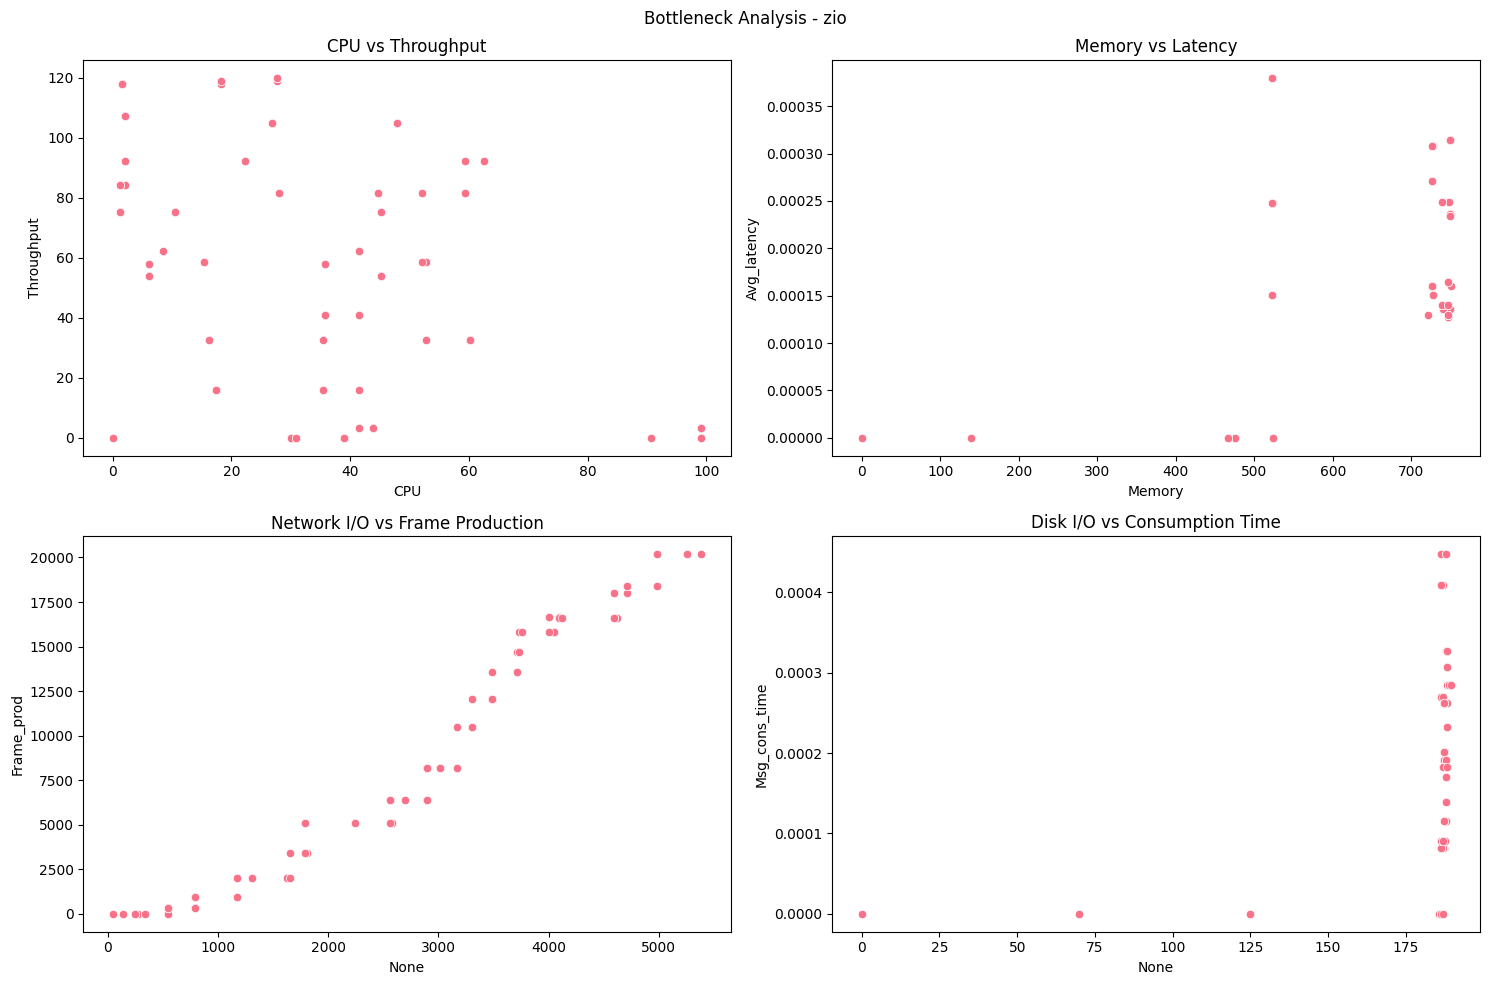

Detected Bottlenecks: ['High CPU (>90%)', 'High Memory (top 10%)']

[RESOURCE EFFICIENCY]


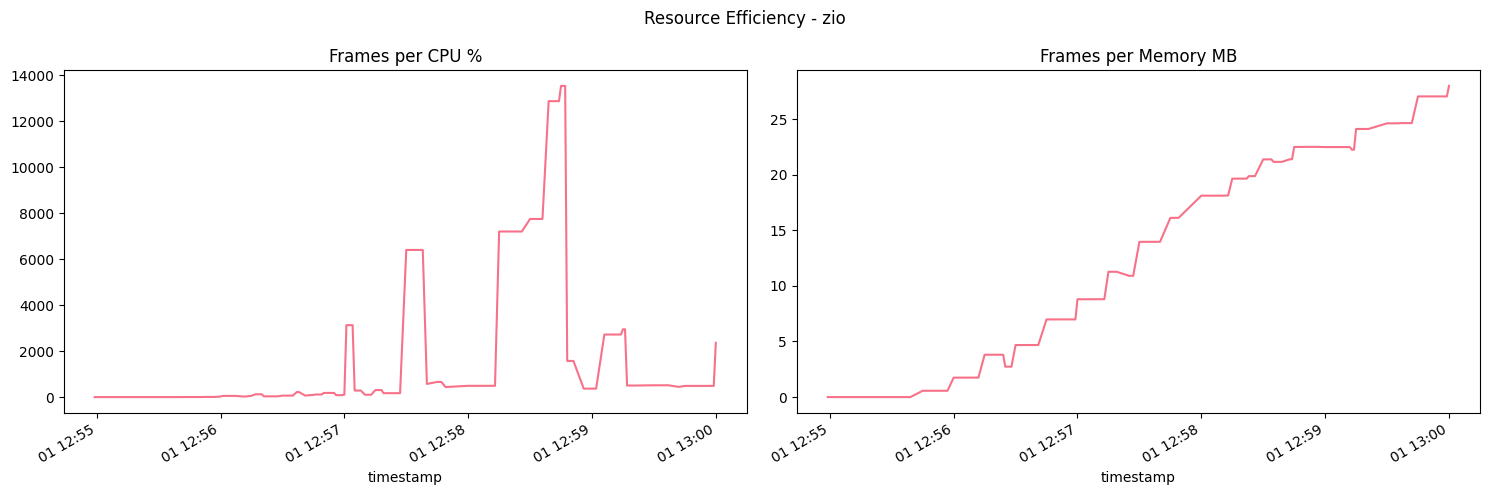

CPU Efficiency: 1827.59 frames/%
Memory Efficiency: 11.20 frames/MB

ANALYZING: CATS

[INFRASTRUCTURE VS PERFORMANCE CORRELATIONS]


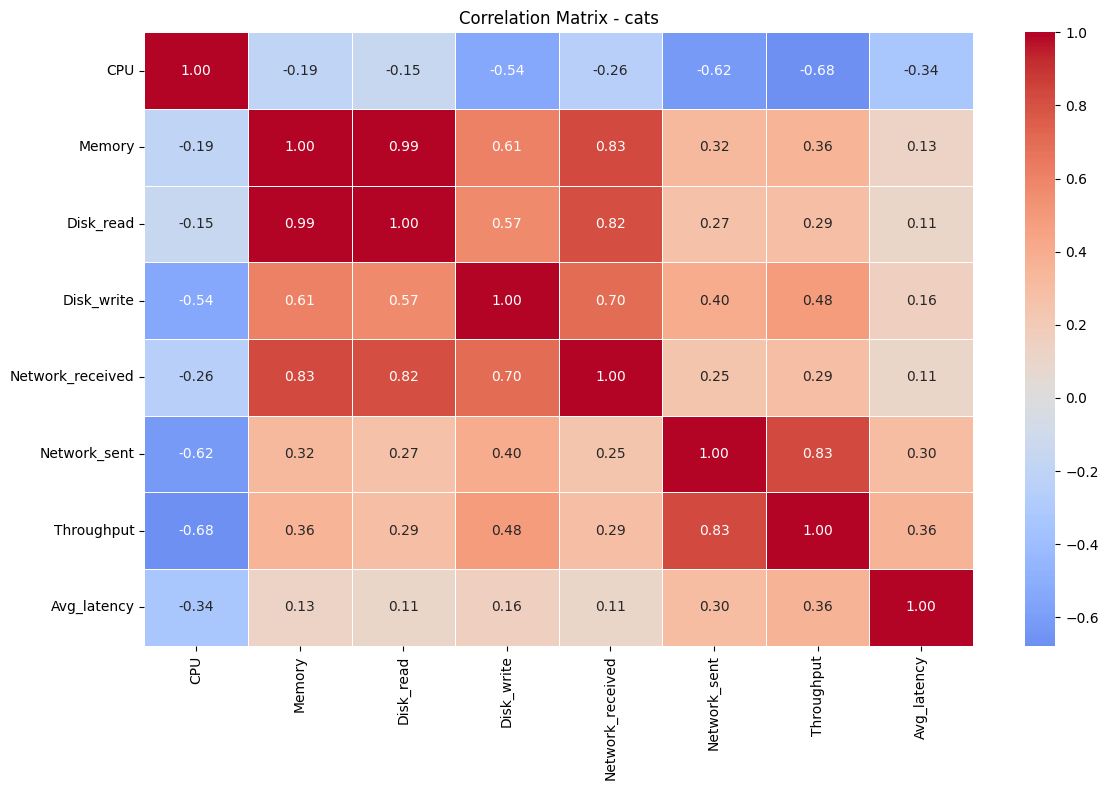


[TIME SERIES DECOMPOSITION]


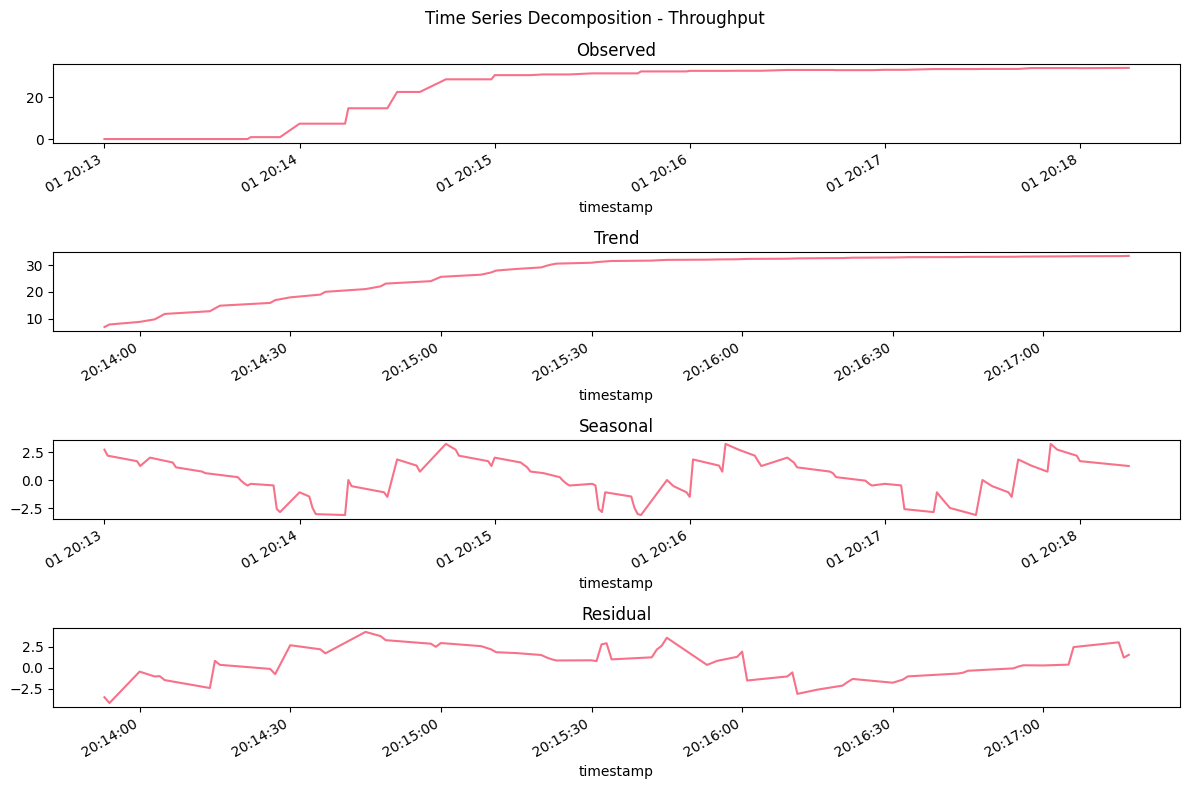


[BOTTLENECK ANALYSIS]


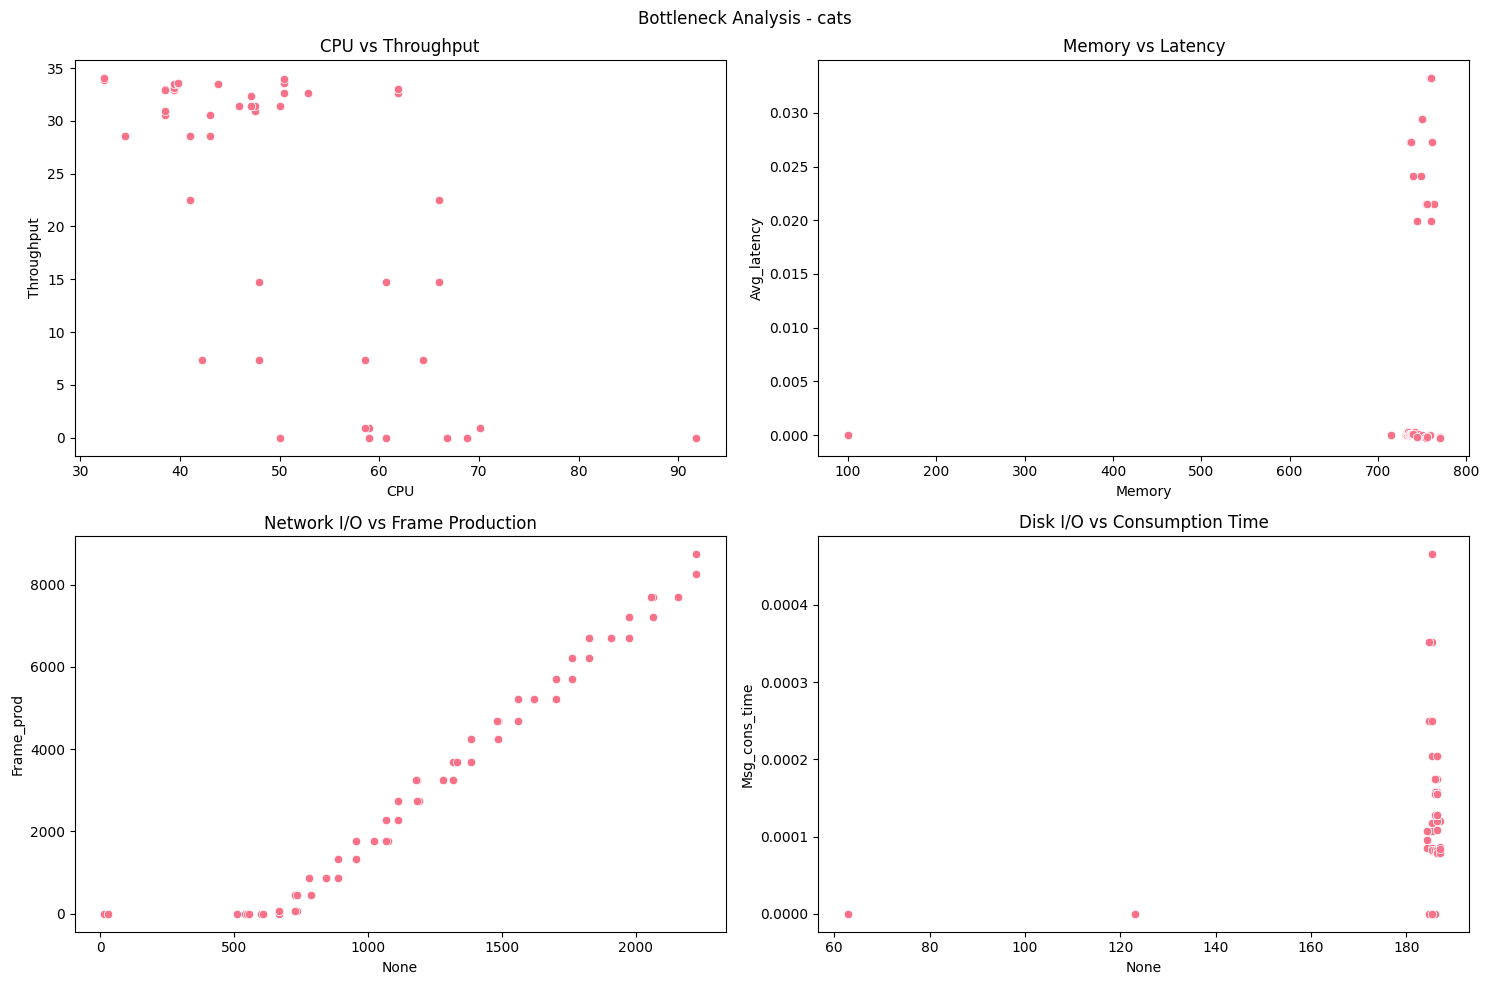

Detected Bottlenecks: ['High CPU (>90%)', 'High Memory (top 10%)']

[RESOURCE EFFICIENCY]


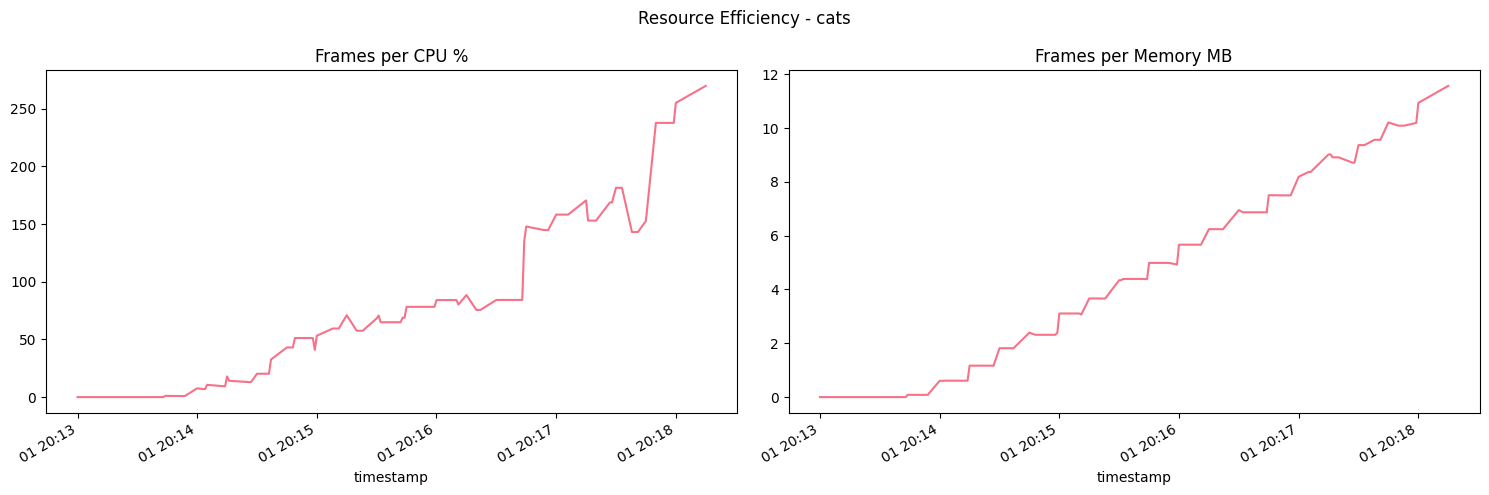

CPU Efficiency: 79.12 frames/%
Memory Efficiency: 4.55 frames/MB


In [66]:
if __name__ == "__main__":
    # Load all data
    producers_data = load_all_producers()
    
    # Generate complete report
    if producers_data:
        generate_report(producers_data)
    else:
        print("No valid producer data found!")